# Quanto dinheiro vivo está circulando no Brasil?

In [1]:
# para coleta
import requests

# para tratamento de dados
import pandas as pd
import datetime as dt
from io import StringIO

# para gráficos
import matplotlib.pyplot as plt

Há uma API pública do Banco Central que disponibiliza as informações de cédulas/moedas circulando no Brasil (meio circulante), por dia, desde 1994 com a implementação do Real.

Link: https://dados.gov.br/dataset/dinheiro-em-circulao

In [2]:
def get_data():

    # base de dados pública do banco central brasileiro
    url = 'https://olinda.bcb.gov.br/olinda/servico/mecir_dinheiro_em_circulacao/versao/v1/odata/informacoes_diarias?%24format=text%2Fcsv'

    req = requests.get(url)

    # retorna .csv em formato de string pura
    data = req.text

    # constrói dataframe
    df = pd.read_csv(StringIO(data), decimal = ',', parse_dates = ['Data'])

    # constrói colunas de quantidade/valor na casa dos bilhões/milhões, para facilitar a análise
    df['Qtd_Bi'] = df['Quantidade'] / 1e9
    df['Qtd_Mi'] = df['Quantidade'] / 1e6
    df['Valor_Bi'] = df['Valor'] / 1e9
    df['Valor_Mi'] = df['Valor'] / 1e6
    
    # constrói coluna de ano-mês
    df['Ano_Mês'] = df['Data'].dt.year.astype(str) + '-' + df['Data'].dt.month.astype(str).apply(lambda x: x.zfill(2))
        
    return df

df = get_data()

df.head()

,Data,Quantidade,Valor,Denominacao,Especie,Qtd_Bi,Qtd_Mi,Valor_Bi,Valor_Mi,Ano_Mês
0,1994-10-03,692701959,6.927020e+06,0.01,Moedas,0.692702,692.701959,0.006927,6.927020,1994-10
1,1994-10-03,462277579,2.311388e+07,0.05,Moedas,0.462278,462.277579,0.023114,23.113879,1994-10
2,1994-10-03,404559065,4.045591e+07,0.10,Moedas,0.404559,404.559065,0.040456,40.455906,1994-10
3,1994-10-03,1492870,3.732175e+05,0.25,Moedas,0.001493,1.492870,0.000373,0.373217,1994-10
4,1994-10-03,278901842,1.394509e+08,0.50,Moedas,0.278902,278.901842,0.139451,139.450921,1994-10


A primeira análise que podemos fazer é da série histórica. Nota-se que até 2012 o meio circulante seguia uma curva aproximadamente exponencial.

Entre 2015 e o começo da pandemia, o crescimento no meio circulante foi aproximadamente linear.

Com a pandemia, houve uma explosão no meio circulante, dadas as políticas de assistência como o auxílio emergencial.

Porém, estamos vivendo pela primeira vez na história uma redução no meio circulante. Uma possível razão pode ser o avanço de tecnologias como o PIX, que se torna cada vez mais popular no país.

---

Gráfico abaixo.

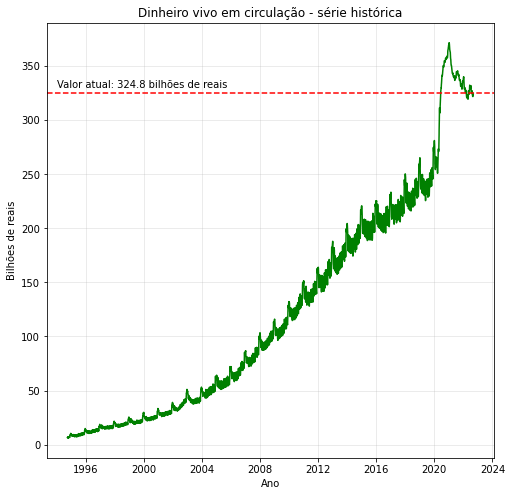

In [3]:
# criando df temporário, agrupando por dia (removendo espécies e denominações)
df_por_dia = df.groupby(df['Data']).sum()
valor_atual = df_por_dia['Valor_Bi'][-1]

# gráfico
plt.figure(figsize = (8, 8))
plt.plot(df_por_dia['Valor_Bi'], color = 'green')
plt.axhline(valor_atual, color = 'red', linestyle = '--')
plt.grid(alpha = 0.3)

# anotações
plt.annotate(f'Valor atual: {valor_atual.round(2)} bilhões de reais', (dt.datetime(1994, 1, 1), valor_atual + 5))
plt.title('Dinheiro vivo em circulação - série histórica')
plt.xlabel('Ano')
plt.ylabel('Bilhões de reais')
plt.show();

# Analisando moedas

Valor circulante hoje: 7.73 bilhões de reais em moedas
Quantidade circulante hoje: 29.16 bilhões de moedas

Participação atual de moedas, em valor (%):  2.38 %
Participação atual de moedas, em quantidade (%):  79.88 %


<Figure size 576x576 with 0 Axes>

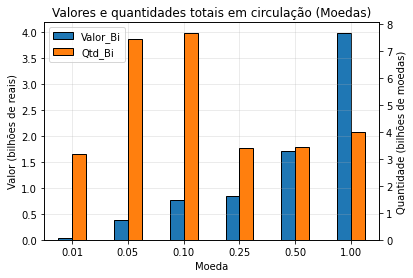

In [4]:
# Observando apenas moedas, por curiosidade, na presente data.

# filtrando último dia para calcular valores atuais
ultimo_dia_moedas = df[df['Data'] == df['Data'].max()].query('Especie == "Moedas"').reset_index(drop = True)

# calculando valores e quantidades totais de moedas
valor_total_moedas = ultimo_dia_moedas['Valor_Bi'].sum()
qtd_total_moedas = ultimo_dia_moedas['Qtd_Bi'].sum()

print(f'Valor circulante hoje: {valor_total_moedas.round(2)} bilhões de reais em moedas')
print(f'Quantidade circulante hoje: {qtd_total_moedas.round(2)} bilhões de moedas\n')

# calculando total (incluindo cédulas)
valor_total = df[df['Data'] == df['Data'].max()]['Valor_Bi'].sum()
qtd_total = df[df['Data'] == df['Data'].max()]['Qtd_Bi'].sum()

# calculando participação de moedas no total (incluindo cédulas)
print('Participação atual de moedas, em valor (%): ', round(valor_total_moedas * 100 / valor_total, 2), '%')
print('Participação atual de moedas, em quantidade (%): ', round(qtd_total_moedas * 100 / qtd_total, 2), '%')

# gráfico
plt.figure(figsize = (8, 8))

ax = ultimo_dia_moedas[['Valor_Bi', 'Qtd_Bi']].plot.bar(secondary_y = 'Qtd_Bi', edgecolor = 'black', rot = 0, mark_right = False)
ax.set_ylabel('Valor (bilhões de reais)')
ax.set_xlabel('Moeda')
ax.grid(alpha = 0.3)

# anotações
plt.title('Valores e quantidades totais em circulação (Moedas)')
plt.xticks(range(6), ultimo_dia_moedas['Denominacao'].unique())
plt.ylabel('Quantidade (bilhões de moedas)');

Como é de se esperar, as moedas participam pouco (2%) do valor total.

---

Quantas moedas "novas" aparecem diariamente no país? Pode-se calcular a diferença na quantidade de moedas entre dois dias consecutivos.

Curiosamente, não há variação negativa no número de moedas em 2022. Sempre aparecem mais. Ficam guardadas? Esquecidas?

Exemplo:

Data
2022-08-31    29149.817185
2022-09-01    29151.921185
2022-09-02    29154.498686
2022-09-05    29155.638086
2022-09-06    29159.499573
Name: Qtd_Mi, dtype: float64 

Data
2022-08-31    3.591873
2022-09-01    2.104000
2022-09-02    2.577501
2022-09-05    1.139400
2022-09-06    3.861487
Name: Qtd_Mi, dtype: float64


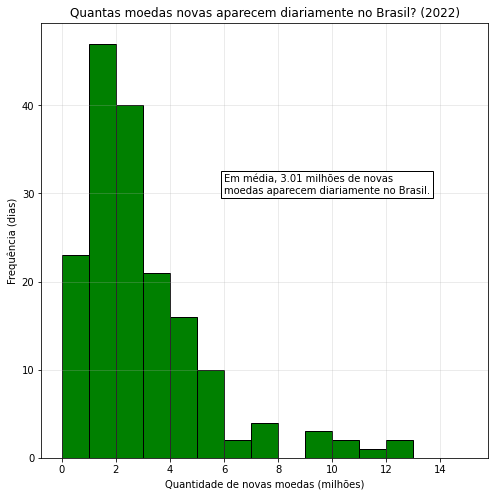

In [5]:
moedas_dia = df.query('Especie == "Moedas"').groupby('Data').sum()['Qtd_Mi'] # em milhões de moedas

# analisando 2022 (informação mais atual)
moedas_dia_2022 = moedas_dia['2022-01-01':]

# diff() indica a diferença entre o valor atual e o valor em D-1
print('Exemplo:\n')
print(moedas_dia_2022.tail(), '\n')
print(moedas_dia_2022.diff().tail())

media = moedas_dia_2022.diff().mean()
mediana = moedas_dia_2022.diff().median()

# histograma com quantidades diárias de novas moedas em circulação
plt.figure(figsize = (8, 8))
plt.hist(moedas_dia_2022.diff(), bins = range(0, 16, 1), edgecolor = 'black', color = 'green')
plt.grid(alpha = 0.3)

plt.annotate(f'Em média, {round(media, 2)} milhões de novas\nmoedas aparecem diariamente no Brasil.', (6, 30), bbox = dict(boxstyle = 'square', fc = 'white', ec = 'black'))
plt.title('Quantas moedas novas aparecem diariamente no Brasil? (2022)')
plt.xlabel('Quantidade de novas moedas (milhões)')
plt.ylabel('Frequência (dias)')
plt.show()

A última vez que moedas diminuíram em volume foi em abril de 2016: Há mais de 6 anos!

In [6]:
moedas_dia.diff()[moedas_dia.diff() < 0]

Data
1994-11-03    -8.716962
1994-11-07    -6.855451
1994-11-14    -3.717531
1994-11-22    -6.059454
1994-11-28   -11.216194
                ...    
2006-05-31    -0.058684
2006-06-27    -0.606000
2006-07-19    -0.029118
2007-02-27    -3.374101
2016-04-18    -0.332956
Name: Qtd_Mi, Length: 105, dtype: float64

Os 10 dias com maiores volumes de emissão de novas moedas. Destes 10 dias, 6 ocorreram nos últimos 3 meses.

In [7]:
moedas_dia_2022.diff().nlargest(10)

Data
2022-02-16    12.587500
2022-04-01    12.338200
2022-05-19    11.099850
2022-07-12    10.582000
2022-01-12    10.023500
2022-06-20     9.942500
2022-08-05     9.660500
2022-06-22     9.371133
2022-08-23     7.756500
2022-07-14     7.538000
Name: Qtd_Mi, dtype: float64

Em quais dias da semana aparecem mais moedas?

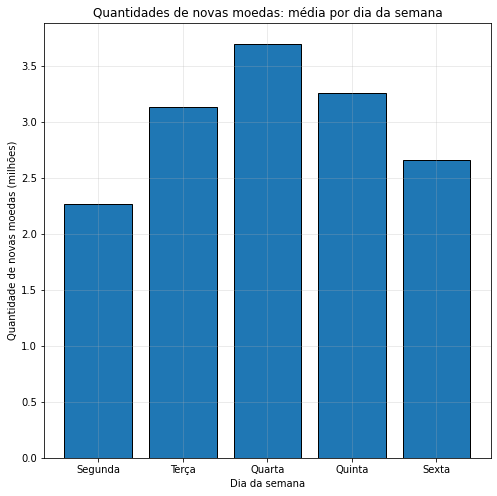

In [8]:
plt.figure(figsize = (8, 8))
plt.bar(['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta'], moedas_dia_2022.diff().groupby(moedas_dia_2022.index.weekday).mean(), edgecolor = 'black')
plt.grid(alpha = 0.3)
plt.title('Quantidades de novas moedas: média por dia da semana')
plt.ylabel('Quantidade de novas moedas (milhões)')
plt.xlabel('Dia da semana');

## Analisando cédulas

In [9]:
# A partir daqui, as análises considerarão apenas a espécie "Cédula" por representar a larga maioria.

df = df.query('Especie == "Cédulas"').reset_index(drop = True)

# Para analisar as denominações, é preciso transformá-la numa variável categórica ordenada.
from pandas.api.types import CategoricalDtype

denominacao_cat = CategoricalDtype(categories = ['1.00', 
                                                 '2.00', 
                                                 '5.00', 
                                                 '10.00', 
                                                 '20.00', 
                                                 '50.00', 
                                                 '100.00', 
                                                 '200.00'], ordered = True)

df['Denominacao'] = df['Denominacao'].astype(denominacao_cat)

df.head()

,Data,Quantidade,Valor,Denominacao,Especie,Qtd_Bi,Qtd_Mi,Valor_Bi,Valor_Mi,Ano_Mês
0,1994-10-03,267853898,2.678539e+08,1.00,Cédulas,0.267854,267.853898,0.267854,267.853898,1994-10
1,1994-10-03,252922174,1.264611e+09,5.00,Cédulas,0.252922,252.922174,1.264611,1264.610870,1994-10
2,1994-10-03,273630983,2.736310e+09,10.00,Cédulas,0.273631,273.630983,2.736310,2736.309830,1994-10
3,1994-10-03,28945486,1.447274e+09,50.00,Cédulas,0.028945,28.945486,1.447274,1447.274300,1994-10
4,1994-10-03,2841789,2.841789e+08,100.00,Cédulas,0.002842,2.841789,0.284179,284.178900,1994-10


A distribuição atual de notas é vista a seguir. Notas de 50 e 100 compõem a grande maioria do valor circulante,
enquanto notas de 200 já superam o valor de notas menores mesmo tendo sido lançada há pouquíssimo tempo.

<Figure size 576x576 with 0 Axes>

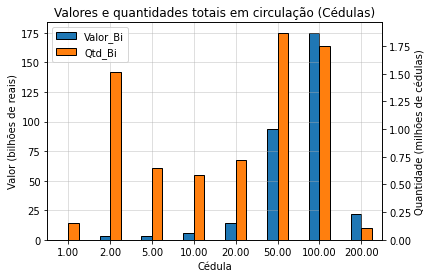

In [10]:
ultimo_dia = df[df['Data'] == df['Data'].max()]

plt.figure(figsize = (8, 8))

ax = ultimo_dia[['Valor_Bi', 'Qtd_Bi']].plot.bar(secondary_y = 'Qtd_Bi', edgecolor = 'black', rot = 0, mark_right = False)
ax.grid(alpha = 0.5)
ax.set_ylabel('Valor (bilhões de reais)')
ax.set_xlabel('Cédula')

plt.title('Valores e quantidades totais em circulação (Cédulas)')
plt.xticks(range(8), ultimo_dia['Denominacao'].unique().tolist())
plt.ylabel('Quantidade (milhões de cédulas)');

Quantas cédulas "novas" aparecem diariamente no país?
Pode-se calcular a diferença na quantidade de cédulas entre dois dias consecutivos.

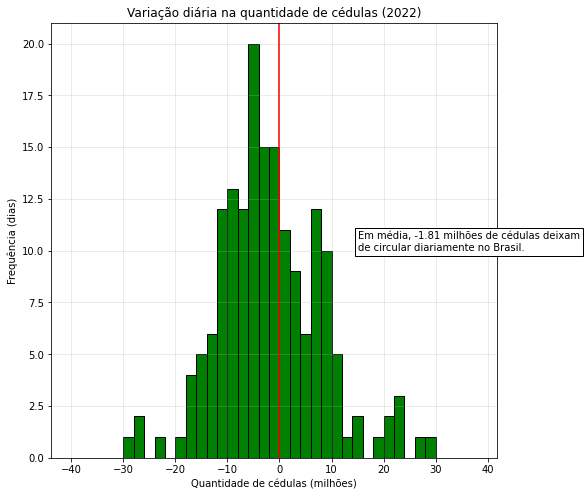

In [11]:
cedulas_dia = df.groupby('Data').sum()['Qtd_Mi'] # em milhões de cédulas

# analisando 2022 (informação mais atual)
cedulas_dia_2022 = cedulas_dia['2022-01-01':]

media = cedulas_dia_2022.diff().mean()
mediana = cedulas_dia_2022.diff().median()

# histograma com quantidades diárias de novas cédulas em circulação
plt.figure(figsize = (8, 8))
plt.hist(cedulas_dia_2022.diff(), bins = range(-40, 40, 2), edgecolor = 'black', color = 'green')
plt.axvline(0, color = 'red')
plt.grid(alpha = 0.3)

plt.annotate(f'Em média, {round(media, 2)} milhões de cédulas deixam\nde circular diariamente no Brasil.', (15, 10), bbox = dict(boxstyle = 'square', fc = 'white', ec = 'black'))
plt.title('Variação diária na quantidade de cédulas (2022)')
plt.xlabel('Quantidade de cédulas (milhões)')
plt.ylabel('Frequência (dias)')
plt.show()

Nota-se que a variação diária é, em média, negativa. Isso corrobora a análise da série histórica no começo deste material: estamos na primeira queda da história do meio circulante.

---

Em quais dias da semana há mais variação no meio circulante?

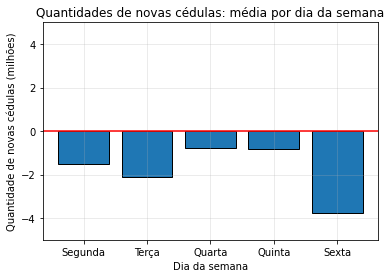

In [12]:
plt.bar(['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta'], cedulas_dia_2022.diff().groupby(cedulas_dia_2022.index.weekday).mean(), edgecolor = 'black')
plt.grid(alpha = 0.3)
plt.title('Quantidades de novas cédulas: média por dia da semana')
plt.ylabel('Quantidade de novas cédulas (milhões)')
plt.ylim(-5, 5)
plt.axhline(0, color = 'red')
plt.xlabel('Dia da semana');

Como é esta mesma variação semanal, por cédula?

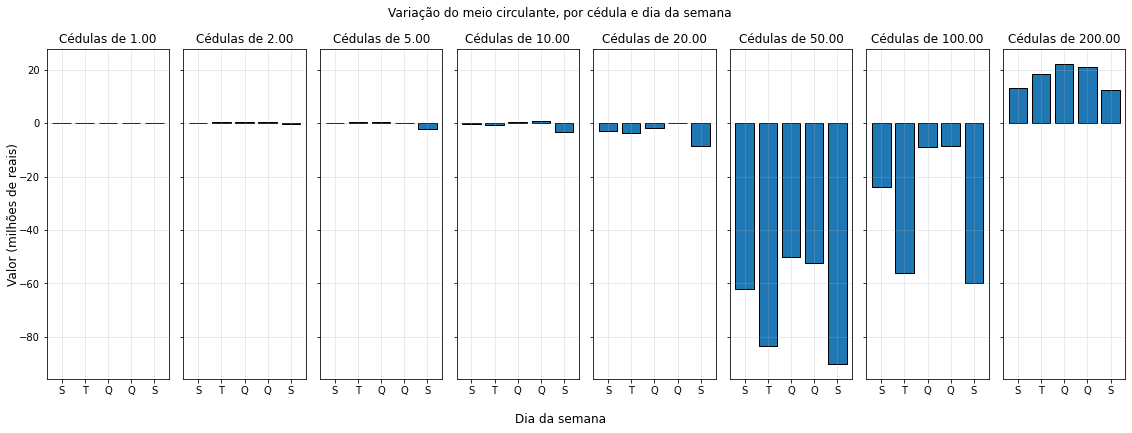

In [13]:
# gráfico
fig, ax = plt.subplots(1, 8, figsize = (16, 6), sharey = 'all')
fig.suptitle('Variação do meio circulante, por cédula e dia da semana')
fig.supylabel('Valor (milhões de reais)')
fig.supxlabel('Dia da semana')

# auxiliar
i = 0
j = 0

# para cada cédula:
for ced in df['Denominacao'].sort_values().unique().tolist():

    # filtrando cédula
    temp = df[df['Denominacao'] == ced].reset_index(drop = True)
    cedulas_dia = temp.groupby('Data').sum()['Valor_Mi'] # em milhões de cédulas
    cedulas_dia_2022 = cedulas_dia['2022-01-01':]
    
    # criando gráfico
    ax[j].bar(['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta'], cedulas_dia_2022.diff().groupby(cedulas_dia_2022.index.weekday).mean(), edgecolor = 'black')
    ax[j].grid(alpha = 0.3)
    ax[j].set_title(f'Cédulas de {ced}')
    ax[j].set_xticks(range(5), ['S', 'T', 'Q', 'Q', 'S']);
    
    """
    if j == 3:
        i += 1
        j = 0
    
    else:
        j += 1"""
    
    j += 1
        
plt.tight_layout()